# "Communication-free and Parallel Simulation of Neutral Biodiversity Models": Visual Playground with Noisy Landscape

In [1]:
import hashlib

from pathlib import Path

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import demo

## Helper function to visualise the species distribution

In [2]:
def visualise_species(df, x, y, width, height, borders=True):
    side = max(width, height)
    
    fig, ax = plt.subplots(1, 1, figsize=(10*width/side, 10*height/side))

    # Plot species in relative (0, width)x(0, height) space
    X, Y = np.meshgrid(
        np.arange(-0.5, width+0.5, 1),
        np.arange(-0.5, height+0.5, 1),
        indexing='xy',
    )
    Z = np.zeros(shape=(height, width), dtype=int)

    species = { None: 0 }
    colours = [(1,1,1)]

    # Collect all species in the output
    # Hash their species identities to assign their colours
    for _, e in df.iterrows():
        sid = species.get(e["species"])

        if sid is None:
            sid = len(species)
            species[e["species"]] = sid

            h = hashlib.sha3_512()
            h.update(e["species"])
            r, g, b = h.digest()[:3]

            colours.append((r/255,g/255,b/255))

        Z[(e["y"]-y)%(2**32), (e["x"]-x)%(2**32)] = sid
        
    cmap = mpl.colors.LinearSegmentedColormap.from_list("species", colours, N=len(colours))

    # Draw the species membership grid
    ax.pcolormesh(X, Y, Z, shading='flat', cmap=cmap)
    
    if borders:
        # Add outlines between species membership changes
        for yy in range(0, height):
            for xx in range(0, width-1):
                if Z[yy,xx] != Z[yy,xx+1]:
                    ax.plot([xx+0.5,xx+0.5], [yy-0.5,yy+0.5], c='black')

        for xx in range(0, width):
            for yy in range(0, height-1):
                if Z[yy,xx] != Z[yy+1,xx]:
                    ax.plot([xx-0.5,xx+0.5], [yy+0.5,yy+0.5], c='black')
                
    def fti(x):
        return int(x) if int(x) == x else float(x)
    
    # Adjust the axis tick labels to reflect the proper coordinates
    ax.xaxis.set_major_formatter(lambda p, _: str(fti(p+x)%int(2**32)))
    ax.yaxis.set_major_formatter(lambda p, _: str(fti(p+y)%int(2**32)))

    plt.show()

## `rustcoalescence` simulation configuration

In the `WrappingNoise` scenario, individuals live on a wrapping torus landscape with $x \in [0; 2^{32}-1]$ and $y \in [0; 2^{32}-1]$. Each location $(x, y)$ has either habitat for exactly one individual or is inhabitable depending on a OpenSimpleNoise sample at the location.

The scenario has the following configuration parameters:
- `seed`: random seed $\in [-2^{63}; 2^{63}-1]$ for the noise
- `scale`: scale of the noise $\in (0.0; 1.0]$
- `persistence`: geometric persistence factor $\in (0.0; 1.0]$ across several octaves of noise
- `octaves`: number of octaves $\gt 0$ of noise to add up
- `coverage`: fraction of the landscape $\in [0.0; 1.0]$ that is habitable
- `sample`: extent (origin, width, height) of the landscape from which individuals are simulated
- `sigma`: standard deviation $\ge 0.0$ for the normal individual dispersal kernel $\text{N}(0, \sigma^2)$

If plotting takes too much time, you can turn off the species outline with `borders=False`.


=========================== Simulation Configuration ===========================

(
    speciation: 0.001,
    sample: Sample(
        percentage: 1.0,
        origin: Habitat,
        mode: Genesis,
    ),
    pause: None,
    rng: Seed(42),
    scenario: WrappingNoise(
        seed: 42,
        coverage: 0.6,
        scale: 0.025,
        persistence: 0.5,
        octaves: 8,
        sample: Extent(
            x: 4294967246,
            y: 4294967271,
            width: 100,
            height: 50,
        ),
        sigma: 1.0,
    ),
    algorithm: Independent(
        delta_t: 2.0,
        step_slice: 10,
        dedup_cache: Relative(
            factor: 1.0,
        ),
        parallelism_mode: Monolithic(
            event_slice: Relative(
                factor: 2.0,
            ),
        ),
    ),
    partitioning: Monolithic(),
    log: None,
    reporters: [
        Plugin(
            library: "plugins/common.so",
            reporters: [
                Progress(),
   

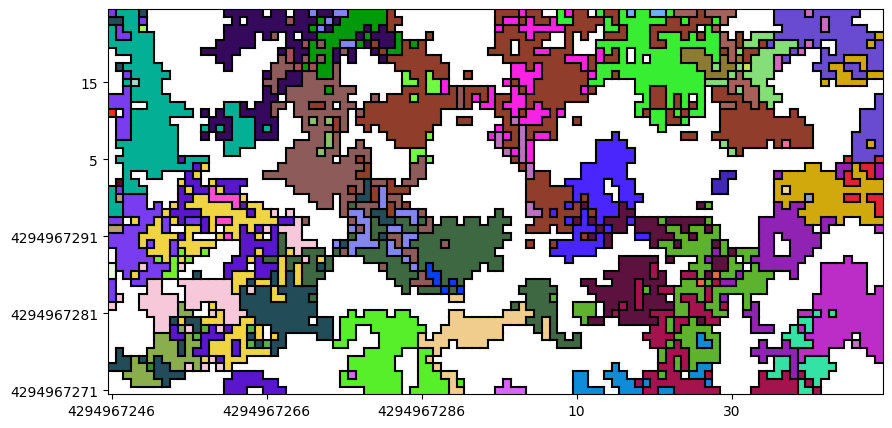

In [3]:
# Remove the previous simulation output
Path("species.ft").unlink(missing_ok=True)

# Configure the sample extent of the simulation
x = 2**32 - 50
y = 2**32 - 25

width = 100
height = 50

# Run rustcoalescence
!rustcoalescence simulate '(
    speciation: 0.001,
    sample: Sample(percentage: 1.0),
    rng: Seed(42),
    
    algorithm: Independent(),

    scenario: WrappingNoise(
        seed: 42,
        scale: 0.025,
        persistence: 0.5,
        octaves: 8,
        coverage: 0.6,
        sample: Extent(x: {x}, y: {y}, width: {width}, height: {height}),
        sigma: 1.0,
    ),
    
    reporters: [
        Plugin(
            library: "plugins/common.so",
            reporters: [Progress(), Execution(), Biodiversity()],
        ),
        Plugin(
            library: "plugins/species.so",
            reporters: [IndividualSpeciesFeather(output: "species.ft")],
        ),
    ],
)'

# Visualise the species distribution if the simulation ran successfully
if Path("species.ft").exists():
    visualise_species(pd.read_feather("species.ft"), x=x, y=y, width=width, height=height, borders=True)